<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294776 entries, 0 to 1294775
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1294776 non-null  int64  
 1   name             1294776 non-null  object 
 2   location         1294776 non-null  object 
 3   total_influence  1294776 non-null  float64
 4   country          1206625 non-null  object 
 5   event_type       1294776 non-null  object 
 6   event_action     1294776 non-null  object 
 7   event_time       1294776 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 79.0+ MB


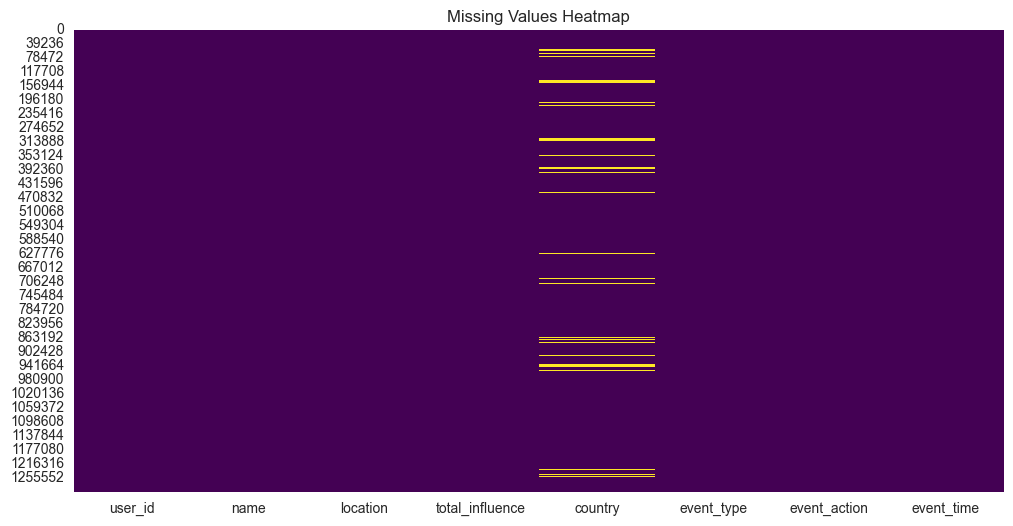

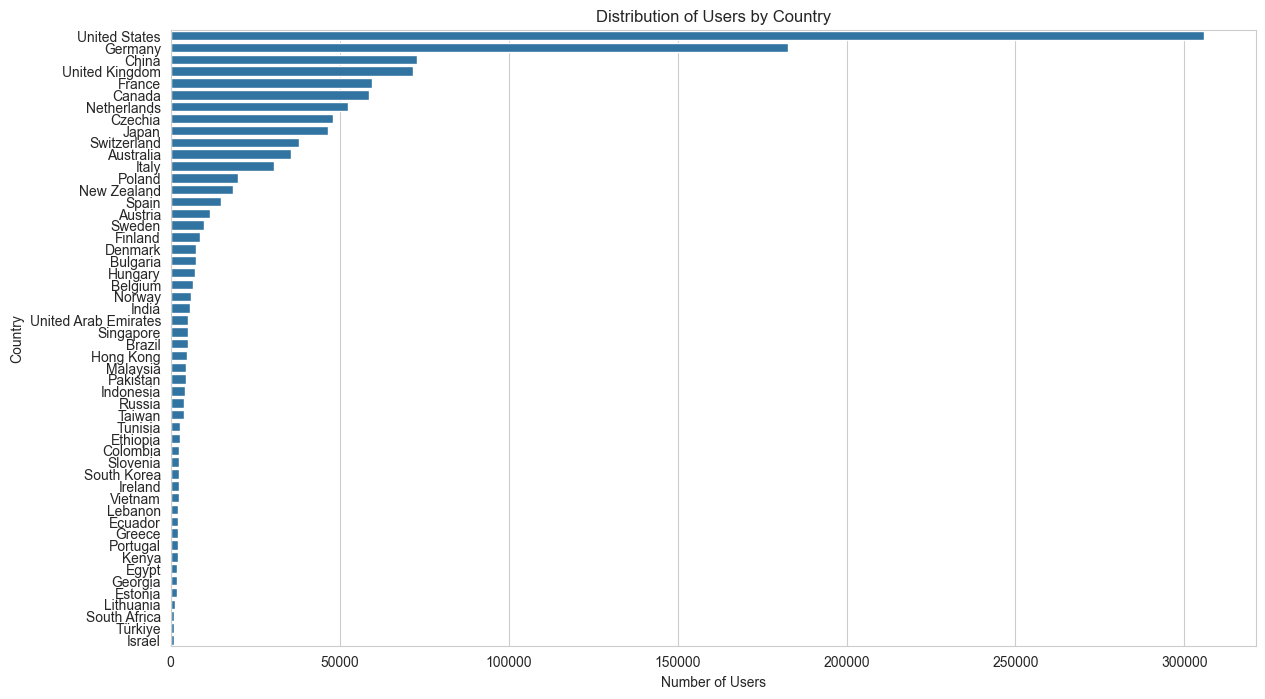

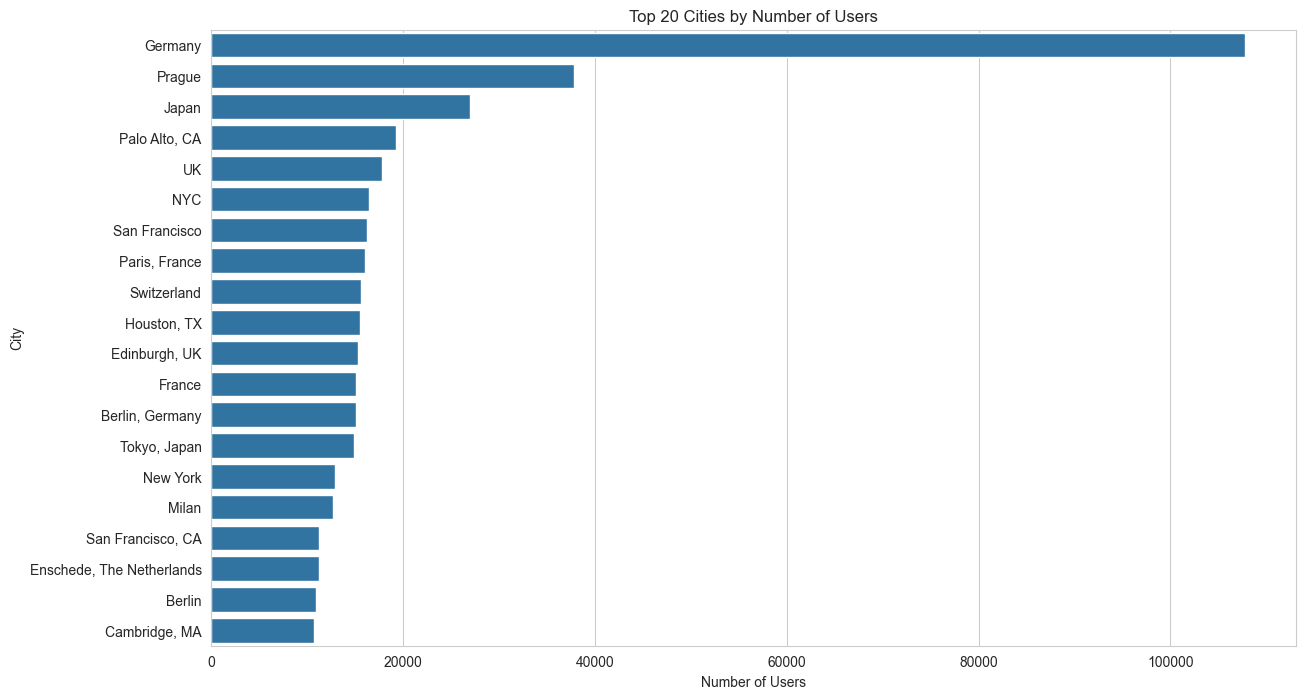

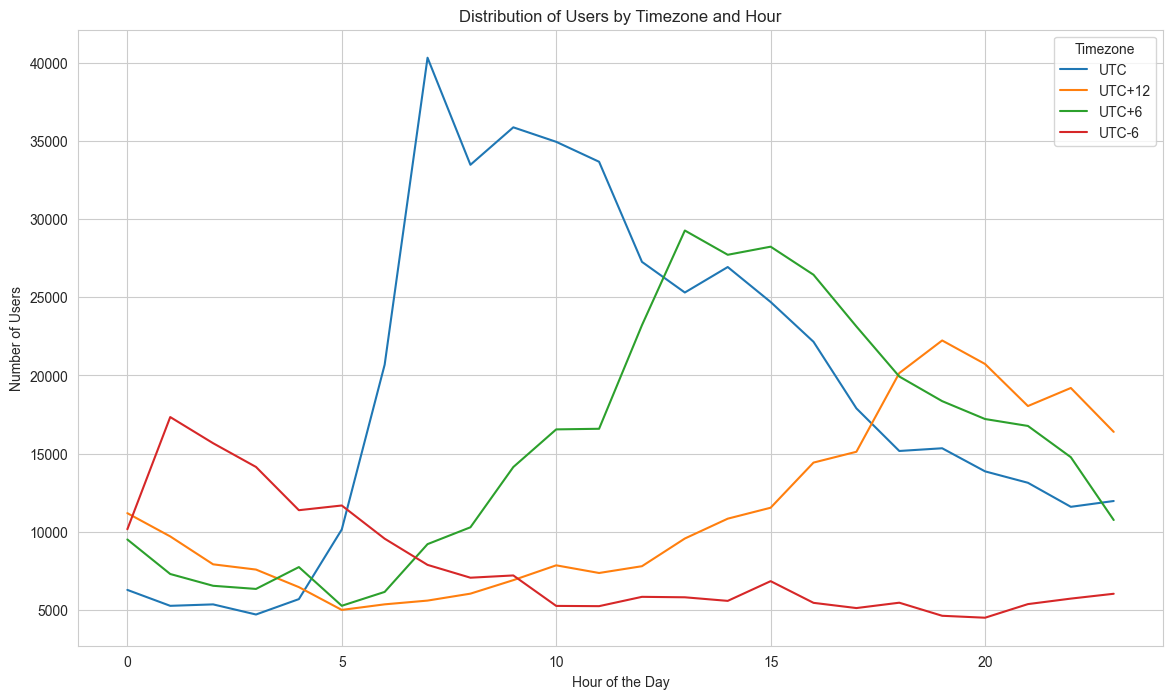

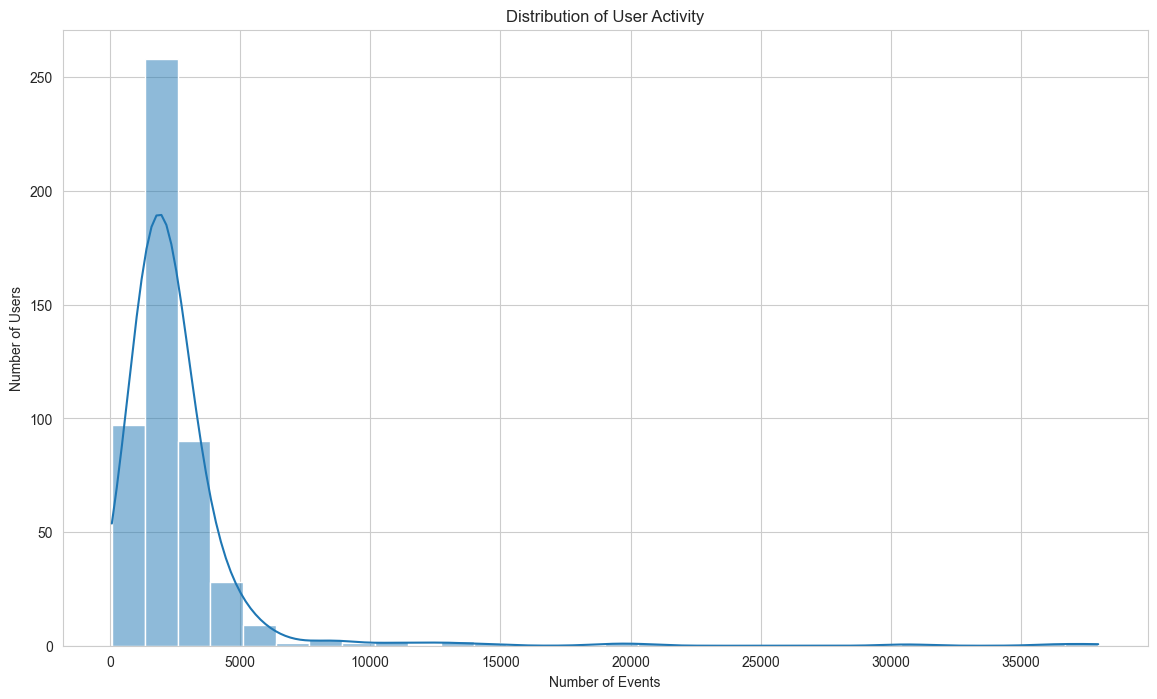

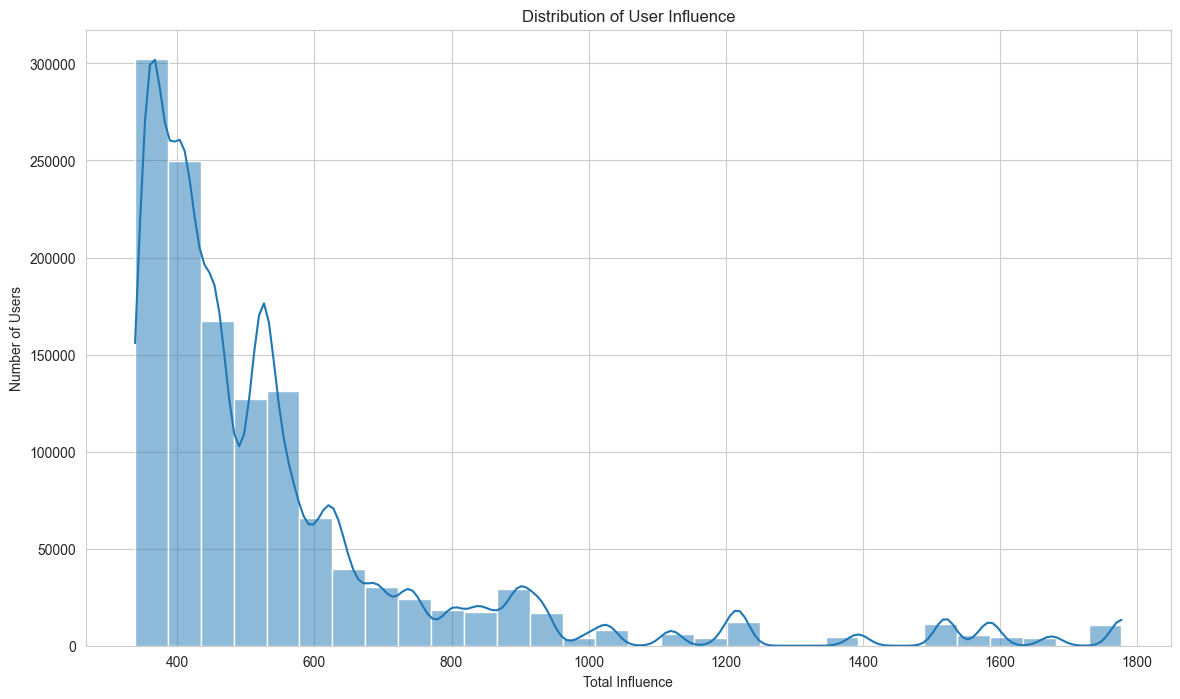

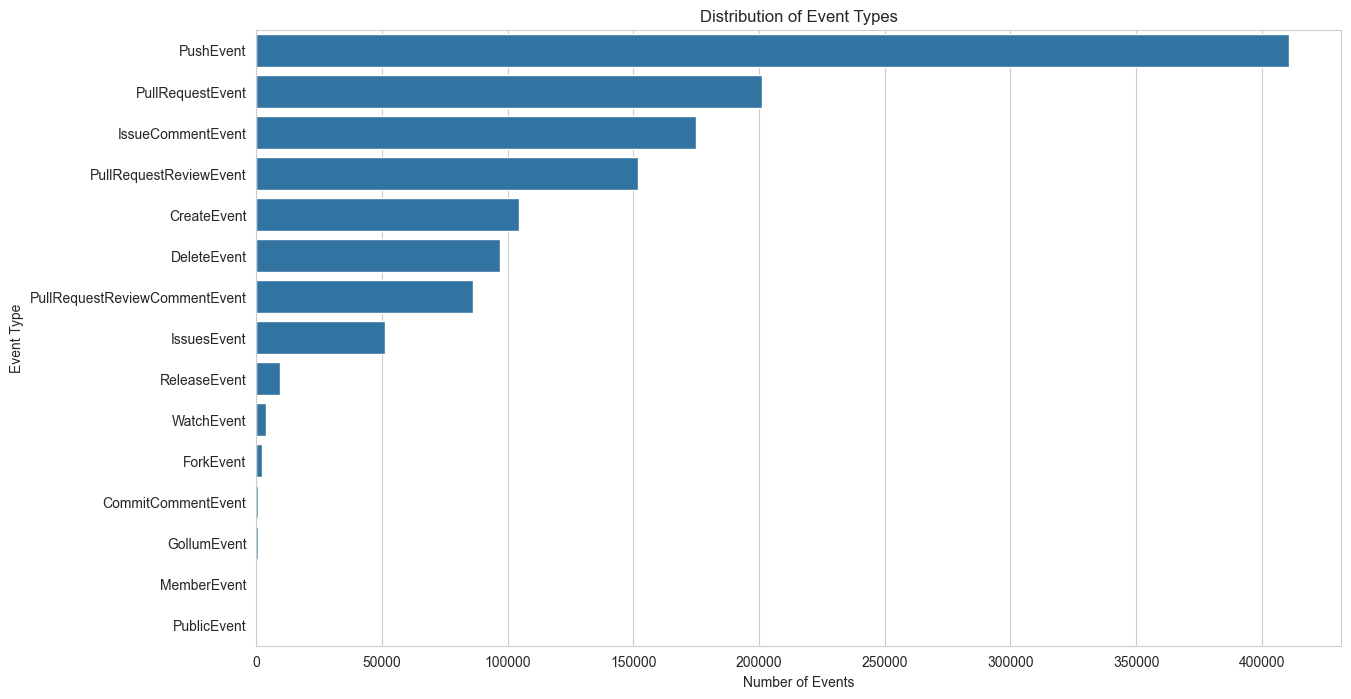

In [3]:
# 数据分析代码

# Import necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone, all_timezones
from datetime import datetime

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Ensure the plots are displayed within the notebook
%matplotlib inline

# Load and Explore Dataset

# Load the dataset
data = pd.read_csv('users_combined_info_500.csv')

# Display the first few rows of the dataset
data.head()

# Display basic information about the dataset
data.info()

# Display summary statistics of the dataset
data.describe()

# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_values

# Visualize the distribution of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# 人口统计分析

# 国家和地区分布

# Group the data by country and count the number of users in each
country_distribution = data.groupby('country').size().reset_index(name='count')

# Display the distribution
country_distribution.head()

# Plot the distribution of users by country
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='country', data=country_distribution.sort_values('count', ascending=False))
plt.title('Distribution of Users by Country')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()

# 城市级别分布

# Group the data by location and count the number of users in each
city_distribution = data.groupby('location').size().reset_index(name='count')

# Display the distribution
city_distribution.head()

# Plot the distribution of users by city
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='location', data=city_distribution.sort_values('count', ascending=False).head(20))
plt.title('Top 20 Cities by Number of Users')
plt.xlabel('Number of Users')
plt.ylabel('City')
plt.show()

# 时区分布

# Convert event_time to datetime
data['event_time'] = pd.to_datetime(data['event_time'])

# Extract hour from the event_time
data['hour'] = data['event_time'].dt.hour

# 推断用户的时区
# 这里假设数据集中有一个列 'timezone' 表示用户的时区
# 如果没有该列，可以根据 'event_time' 推断时区

# Group the data by user_id and hour to analyze user activity patterns
user_hour_distribution = data.groupby(['user_id', 'hour']).size().reset_index(name='count')

# Display the distribution
user_hour_distribution.head()

# 推断用户的时区
def infer_timezone(user_hour_distribution):
    user_timezones = {}
    for user_id, group in user_hour_distribution.groupby('user_id'):
        peak_hour = group.loc[group['count'].idxmax()]['hour']
        if 0 <= peak_hour < 6:
            user_timezones[user_id] = 'UTC-6'
        elif 6 <= peak_hour < 12:
            user_timezones[user_id] = 'UTC'
        elif 12 <= peak_hour < 18:
            user_timezones[user_id] = 'UTC+6'
        else:
            user_timezones[user_id] = 'UTC+12'
    return user_timezones

# Apply the infer_timezone function to the user_hour_distribution
user_timezones = infer_timezone(user_hour_distribution)

# Map the inferred timezones back to the original data
data['timezone'] = data['user_id'].map(user_timezones)

# Group the data by timezone and hour to analyze user activity patterns
timezone_distribution = data.groupby(['timezone', 'hour']).size().reset_index(name='count')

# Display the distribution
timezone_distribution.head()

# Plot the distribution of users by timezone and hour
plt.figure(figsize=(14, 8))
sns.lineplot(x='hour', y='count', hue='timezone', data=timezone_distribution)
plt.title('Distribution of Users by Timezone and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.legend(title='Timezone')
plt.show()

# 协作行为分析

# 提交频率

# Group the data by user_id and count the number of events for each user
user_activity = data.groupby('user_id').size().reset_index(name='count')

# Display the distribution
user_activity.head()

# Plot the distribution of user activity
plt.figure(figsize=(14, 8))
sns.histplot(user_activity['count'], bins=30, kde=True)
plt.title('Distribution of User Activity')
plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.show()

# 其他维度有趣的洞察

# 维度1：用户影响力分布
plt.figure(figsize=(14, 8))
sns.histplot(data['total_influence'], bins=30, kde=True)
plt.title('Distribution of User Influence')
plt.xlabel('Total Influence')
plt.ylabel('Number of Users')
plt.show()

# 维度2：事件类型分布
event_type_distribution = data.groupby('event_type').size().reset_index(name='count')
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='event_type', data=event_type_distribution.sort_values('count', ascending=False))
plt.title('Distribution of Event Types')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plt.show()

# 保存数据洞察报告为PDF
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('data_insights_report.pdf') as pdf:
    # 国家和地区分布图
    plt.figure(figsize=(14, 8))
    sns.barplot(x='count', y='country', data=country_distribution.sort_values('count', ascending=False))
    plt.title('Distribution of Users by Country')
    plt.xlabel('Number of Users')
    plt.ylabel('Country')
    pdf.savefig()
    plt.close()

    # 城市级别分布图
    plt.figure(figsize=(14, 8))
    sns.barplot(x='count', y='location', data=city_distribution.sort_values('count', ascending=False).head(20))
    plt.title('Top 20 Cities by Number of Users')
    plt.xlabel('Number of Users')
    plt.ylabel('City')
    pdf.savefig()
    plt.close()

    # 时区分布图
    plt.figure(figsize=(14, 8))
    sns.lineplot(x='hour', y='count', hue='timezone', data=timezone_distribution)
    plt.title('Distribution of Users by Timezone and Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Users')
    plt.legend(title='Timezone')
    pdf.savefig()
    plt.close()

    # 提交频率图
    plt.figure(figsize=(14, 8))
    sns.histplot(user_activity['count'], bins=30, kde=True)
    plt.title('Distribution of User Activity')
    plt.xlabel('Number of Events')
    plt.ylabel('Number of Users')
    pdf.savefig()
    plt.close()

    # 用户影响力分布图
    plt.figure(figsize=(14, 8))
    sns.histplot(data['total_influence'], bins=30, kde=True)
    plt.title('Distribution of User Influence')
    plt.xlabel('Total Influence')
    plt.ylabel('Number of Users')
    pdf.savefig()
    plt.close()

    # 事件类型分布图
    plt.figure(figsize=(14, 8))
    sns.barplot(x='count', y='event_type', data=event_type_distribution.sort_values('count', ascending=False))
    plt.title('Distribution of Event Types')
    plt.xlabel('Number of Events')
    plt.ylabel('Event Type')
    pdf.savefig()
    plt.close()